## 导包

In [1]:
import torch
import torch.nn as nn
import os
import numpy as np
import pandas as pd
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor, Lambda, Compose

In [2]:
from config import Config
from kits.models import *
from kits.new_models import *
from kits.models_framework import *
from kits.loss import *
from kits.trainer import BaseModelTrainer, ModelTrainer, parse_data
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import torchmetrics
print(torch.cuda.is_available())
print('1')

The Zen of Python, by Tim Peters

Beautiful is better than ugly.
Explicit is better than implicit.
Simple is better than complex.
Complex is better than complicated.
Flat is better than nested.
Sparse is better than dense.
Readability counts.
Special cases aren't special enough to break the rules.
Although practicality beats purity.
Errors should never pass silently.
Unless explicitly silenced.
In the face of ambiguity, refuse the temptation to guess.
There should be one-- and preferably only one --obvious way to do it.
Although that way may not be obvious at first unless you're Dutch.
Now is better than never.
Although never is often better than *right* now.
If the implementation is hard to explain, it's a bad idea.
If the implementation is easy to explain, it may be a good idea.
Namespaces are one honking great idea -- let's do more of those!
True
1


## 数据预处理

In [3]:
from kits.appDataset import *
import time
import copy

## model&参数配置

In [4]:
config = Config
# 数据读取
data = parse_data(config)

In [5]:
# 参数设定
config.epoch = 500
config.checkpoint = False
config.lr = 5e-4
config.wd = 1e-4
# config.checkpoint = True

# 模型初始化
# config.model_name = "DDDNN"
# model = DDDNN(config, config.device)
# print(model)
config.model_name = "MFR"
model = MFR(config,config.device)
print(model)

MFR(
  (app_embeddings): Embedding(15752, 128, padding_idx=0)
  (date_embeddings): Embedding(3551, 128, padding_idx=0)
  (sep_embeddings): Embedding(3516, 128, padding_idx=0)
  (EncoderBlock): ModuleList(
    (0): TransformerEncoder(
      (mutihead_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
      )
      (ffn): Sequential(
        (0): Linear(in_features=128, out_features=256, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
        (2): Dropout(p=0.01, inplace=False)
        (3): Linear(in_features=256, out_features=128, bias=True)
      )
      (layernorm1): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
      (layernorm2): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
    )
    (1): TransformerEncoder(
      (mutihead_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
      )
      (ffn): Sequential(
       

In [6]:
# trained初始化
# framework = BaseModelTrainer(data, config, model)
# framework.fit()

In [7]:
from kits.models import *
import torch

from kits.trainer import parse_data
from config import Config

def user_embedding_loop(dataloader, model, device):
    user_embedding_all = torch.tensor([]).to(device)
    y_age_all = torch.tensor([]).to(device)
    y_gender_all = torch.tensor([]).to(device)
    model.eval()
    with torch.no_grad():
        for X, y in dataloader:
            #X = {key:X[key].to(device) for key in X}
            #y = {key:y[key].to(device) for key in y}

            try:
                pred = model(X,None)
            except BaseException: pred = model(X, None)
            
            user_embedding = pred[0] #output=128*len(dataloader) 128 128
            # print('user_embedding',user_embedding.size()) 128，128
            y_age_batch = y['age']
            y_gender_batch = y['gender']
            
            user_embedding_all = torch.cat((user_embedding_all, user_embedding), 0)
            
            y_age_all = torch.cat((y_age_all, y_age_batch), 0)
            y_gender_all = torch.cat((y_gender_all, y_gender_batch), 0)
    # print(user_embedding_all.size())
    # print(y_age_all.size())
    # print(y_gender_all.size())
    # n = 0
    # assert n != 0, 'n is zero!'
    #        80000，128           80000      80000
    return user_embedding_all, y_age_all, y_gender_all


config = Config
#config.length_his=64

#数据读取
data = parse_data(config)

#模型加载
savePath = 'savepath/'
modelName = config.model_name+'/'
config.has_adapter=False
model_path = savePath + modelName + 'bestmodel.pt'

# Model_dict = {k: v for k, v in Model_dict.items() if k in model.state_dict()}
#读取训练好的权重
# DDNN_lstm
Model_dict = torch.load(model_path)  
# DDNN_lstm_finetune
base_best_model = model 
# print(finetune_model.state_dict())
if 'model_state_dict' in Model_dict:
    Model_dict = Model_dict['model_state_dict']
Model_dict = {k: v for k, v in Model_dict.items()}
model_dict = base_best_model.state_dict()
model_dict.update(Model_dict)

# 加载参数并拼装base和分类器
base_best_model.load_state_dict(model_dict)
model = base_best_model.to(config.device)
# model = Finetune_model(config, model, config.device)


user_embedding_train, y_age_train, y_gender_train = user_embedding_loop(data[0], model, config.device)
user_embedding_valid, y_age_valid, y_gender_valid = user_embedding_loop(data[1], model, config.device)
user_embedding_test, y_age_test, y_gender_test = user_embedding_loop(data[2], model, config.device)

# torch.save(user_embedding_train, 'finetune_data/DDHCNN/user_embedding_train.pt')
# torch.save(user_embedding_valid, 'finetune_data/DDHCNN/user_embedding_valid.pt')
# torch.save(user_embedding_test, 'finetune_data/DDHCNN/user_embedding_test.pt')
# torch.save(y_age_train, 'finetune_data/DDHCNN/y_age_train.pt')
# torch.save(y_age_valid, 'finetune_data/DDHCNN/y_age_valid.pt')
# torch.save(y_age_test, 'finetune_data/DDHCNN/y_age_test.pt')
# torch.save(y_gender_train, 'finetune_data/DDHCNN/y_gender_train.pt')
# torch.save(y_gender_valid, 'finetune_data/DDHCNN/y_gender_valid.pt')
# torch.save(y_gender_test, 'finetune_data/DDHCNN/y_gender_test.pt')

print('done!')

done!


In [8]:
device = torch.device('cuda')
device_cpu = torch.device('cpu')
# X_train, y_age_train, y_gender_train = torch.FloatTensor(user_embedding_train), y_age_train, y_gender_train
# X_valid, y_age_valid, y_gender_valid = torch.FloatTensor(user_embedding_valid), y_age_valid, y_gender_valid
# X_test, y_age_test, y_gender_test = torch.FloatTensor(user_embedding_test), y_age_test, y_gender_test 

X_train, y_age_train, y_gender_train= torch.FloatTensor(user_embedding_train.to(device_cpu)).to(device), \
                                      torch.LongTensor(y_age_train.type(torch.LongTensor).to(device_cpu)).to(device), \
                                      torch.LongTensor(y_gender_train.type(torch.LongTensor).to(device_cpu)).to(device)
X_valid, y_age_valid, y_gender_valid = torch.FloatTensor(user_embedding_valid.to(device_cpu)).to(device), \
                                    torch.LongTensor(y_age_valid.type(torch.LongTensor).to(device_cpu)).to(device), \
                                    torch.LongTensor(y_gender_valid.type(torch.LongTensor).to(device_cpu)).to(device)
X_test, y_age_test, y_gender_test = torch.FloatTensor(user_embedding_test.to(device_cpu)).to(device), \
                                    torch.LongTensor(y_age_test.type(torch.LongTensor).to(device_cpu)).to(device), \
                                    torch.LongTensor(y_gender_test.type(torch.LongTensor).to(device_cpu)).to(device)

train_dataset_age = torch.utils.data.TensorDataset(X_train, y_age_train)
valid_dataset_age = torch.utils.data.TensorDataset(X_valid, y_age_valid)
test_dataset_age = torch.utils.data.TensorDataset(X_test, y_age_test)
train_dataset_gender = torch.utils.data.TensorDataset(X_train, y_gender_train)
test_dataset_gender = torch.utils.data.TensorDataset(X_test, y_gender_test)
valid_dataset_gender = torch.utils.data.TensorDataset(X_valid, y_gender_valid)


train_loader_age = torch.utils.data.DataLoader(dataset=train_dataset_age,
                                           batch_size=config.Batch_Size,
                                           shuffle=True)
test_loader_age = torch.utils.data.DataLoader(dataset=test_dataset_age,
                                           batch_size=config.Batch_Size,
                                           shuffle=True)
train_loader_gender = torch.utils.data.DataLoader(dataset=train_dataset_gender,
                                           batch_size=config.Batch_Size,
                                           shuffle=True)
test_loader_gender = torch.utils.data.DataLoader(dataset=test_dataset_gender,
                                           batch_size=config.Batch_Size,
                                           shuffle=True)

valid_loader_gender = torch.utils.data.DataLoader(dataset=valid_dataset_gender,
                                           batch_size=config.Batch_Size,
                                           shuffle=True)
valid_loader_age = torch.utils.data.DataLoader(dataset=valid_dataset_age,
                                           batch_size=config.Batch_Size,
                                           shuffle=True)

In [9]:
class NeuralNetwork_age(nn.Module):
    def __init__(self):
        super(NeuralNetwork_age, self).__init__()
        self.dnn = nn.Sequential(
            nn.Linear(config.user_dim, config.user_dim//2),
            nn.LeakyReLU(),
            #nn.Dropout(0.2),
            nn.Linear(config.user_dim//2, config.user_dim//4),
            nn.LeakyReLU(),
            #nn.Dropout(0.2),
            nn.Linear(config.user_dim//4, 5),
            nn.Softmax()
        )

    def forward(self, x):
        x = self.dnn(x)
        return x

class NeuralNetwork_gender(nn.Module):
    def __init__(self):
        super(NeuralNetwork_gender, self).__init__()
        self.dnn = nn.Sequential(
            nn.Linear(config.user_dim, config.user_dim//2),
            nn.LeakyReLU(),
            #nn.Dropout(0.2),
            nn.Linear(config.user_dim//2, config.user_dim//4),
            nn.LeakyReLU(),
            #nn.Dropout(0.2),
            nn.Linear(config.user_dim//4, 2),
            nn.Softmax()
        )

    def forward(self, x):
        x = self.dnn(x)
        return x

In [10]:
def train_loop(dataloader, model, loss_fn, optimizer, epoch):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    epoch_loss = 0
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss

        
        # print('X',X.size()) #128 128
        # n = 0
        # assert n != 0, 'n is zero!'

        pred = model(X)
        # print('pred',pred.size()) #128 5
        # print('y',y.size())
        loss = loss_fn(pred, y)
        

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss = epoch_loss + (loss.item() / num_batches)

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    
    return epoch_loss


def test_loop(dataloader, model, loss_fn, num_class):
    test_acc = torchmetrics.Accuracy().to(device)
    test_recall = torchmetrics.Recall(average='none', num_classes=num_class).to(device)
    test_precision = torchmetrics.Precision(average='none', num_classes=num_class).to(device)
    test_auc = torchmetrics.AUROC(average="macro", num_classes=num_class).to(device)

    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    bestValLoss =  float("inf")
    es = 0
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

            test_acc(pred.argmax(1), y)
            test_auc.update(pred, y)
            test_recall(pred.argmax(1), y)
            test_precision(pred.argmax(1), y)

    test_loss /= num_batches
    epoch_loss = test_loss
    correct /= size

    total_acc = test_acc.compute()
    total_recall = test_recall.compute()
    total_precision = test_precision.compute()
    total_auc = test_auc.compute()

    #print(f"Test Error: \n Accuracy: {(acc):>8f}, Avg loss: {test_loss:>8f} \n")

    print(f"Test Error: \n Accuracy: {(100 * correct):>0.1f}%, "
          f"Avg loss: {test_loss:>8f}, "
          f"torch metrics acc: {(100 * total_acc):>0.1f}%\n")
    print("recall of every test dataset class: ", total_recall.mean())
    print("precision of every test dataset class: ", total_precision.mean())
    print("auc:", total_auc.item())

    return epoch_loss, correct


In [11]:

learning_rate = 1e-4
epochs = 500

NeuralNetwork_age(
  (dnn): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=32, out_features=5, bias=True)
    (5): Softmax(dim=None)
  )
)
Epoch 1
-------------------------------
loss: 1.711361  [    0/80000]


/home/sunyingjie/anaconda3/envs/pytorch_under11.4/lib/python3.8/site-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


loss: 1.603603  [12800/80000]
loss: 1.600254  [25600/80000]
loss: 1.502642  [38400/80000]
loss: 1.546595  [51200/80000]
loss: 1.515934  [64000/80000]
loss: 1.461838  [76800/80000]


/home/sunyingjie/anaconda3/envs/pytorch_under11.4/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


Test Error: 
 Accuracy: 42.2%, Avg loss: 1.470524, torch metrics acc: 42.2%

recall of every test dataset class:  tensor(0.2637, device='cuda:0')
precision of every test dataset class:  tensor(0.2461, device='cuda:0')
auc: 0.6167678833007812
Epoch 2
-------------------------------
loss: 1.428650  [    0/80000]
loss: 1.487598  [12800/80000]
loss: 1.464940  [25600/80000]
loss: 1.460886  [38400/80000]
loss: 1.417281  [51200/80000]
loss: 1.431464  [64000/80000]
loss: 1.444859  [76800/80000]
Test Error: 
 Accuracy: 50.1%, Avg loss: 1.407780, torch metrics acc: 50.1%

recall of every test dataset class:  tensor(0.3314, device='cuda:0')
precision of every test dataset class:  tensor(0.2947, device='cuda:0')
auc: 0.684291422367096
Epoch 3
-------------------------------
loss: 1.399884  [    0/80000]
loss: 1.358819  [12800/80000]
loss: 1.365832  [25600/80000]
loss: 1.357566  [38400/80000]
loss: 1.356217  [51200/80000]
loss: 1.373652  [64000/80000]
loss: 1.358296  [76800/80000]
Test Error: 
 Acc

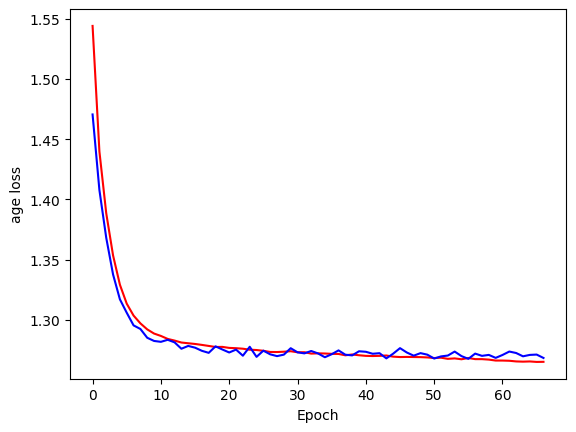

Test Error: 
 Accuracy: 62.6%, Avg loss: 1.274102, torch metrics acc: 62.7%

recall of every test dataset class:  tensor(0.4403, device='cuda:0')
precision of every test dataset class:  tensor(0.3735, device='cuda:0')
auc: 0.7997481226921082
0.6265


In [12]:
model = NeuralNetwork_age().to(device)
print(model)

warmup_epoch = 5
iter_per_epoch = len(train_loader_age)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=0.2, total_iters=20)
# Initialize the loss function
loss_fn = nn.CrossEntropyLoss()

cost = []
val = []

best_correct = 0
bestValLoss = float('inf')
es = 0
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    epoch_loss = train_loop(train_loader_age, model, loss_fn, optimizer, t)
    cost.append(epoch_loss)
    epoch_loss, correct = test_loop(valid_loader_age, model, loss_fn, 5)

    scheduler.step()

    val.append(epoch_loss)
    if correct > best_correct:
        best_correct = correct
    #更新状态
    if epoch_loss < bestValLoss:
        bestValLoss = epoch_loss
        es = 0
    else:
    #early stop
        es += 1
        if es > 10:
            print("early stop!")
            break
print(f"Best Accuracy: {(best_correct):>8f}\n")
print("Done!")

plt.plot(np.squeeze(cost),'-r', np.squeeze(val),'-b')
plt.ylabel('age loss')
plt.xlabel('Epoch')
plt.show()

epoch_loss, correct = test_loop(test_loader_age, model, loss_fn, 5)
print(correct)

NeuralNetwork_gender(
  (dnn): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=32, out_features=2, bias=True)
    (5): Softmax(dim=None)
  )
)
Epoch 1
-------------------------------
loss: 0.811891  [    0/80000]
loss: 0.612708  [12800/80000]
loss: 0.578251  [25600/80000]
loss: 0.504792  [38400/80000]
loss: 0.459603  [51200/80000]
loss: 0.455588  [64000/80000]
loss: 0.437557  [76800/80000]
Test Error: 
 Accuracy: 93.5%, Avg loss: 0.412048, torch metrics acc: 93.5%

recall of every test dataset class:  tensor(0.9336, device='cuda:0')
precision of every test dataset class:  tensor(0.9364, device='cuda:0')
auc: 0.9836854934692383
Epoch 2
-------------------------------
loss: 0.422601  [    0/80000]
loss: 0.388740  [12800/80000]
loss: 0.388348  [25600/80000]
loss: 0.376211  [38400/80000]
loss: 0.4095

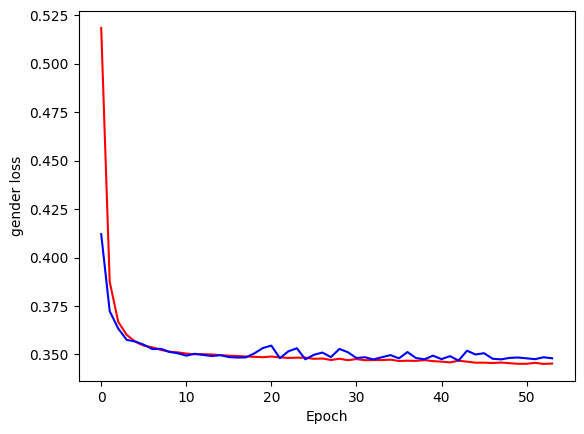

Test Error: 
 Accuracy: 96.4%, Avg loss: 0.348852, torch metrics acc: 96.4%

recall of every test dataset class:  tensor(0.9641, device='cuda:0')
precision of every test dataset class:  tensor(0.9642, device='cuda:0')
auc: 0.9919530153274536
0.9642
2023-04-03 07:27:27


In [13]:
model = NeuralNetwork_gender().to(device)
print(model)

warmup_epoch = 5
iter_per_epoch = len(train_loader_age)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=0.5, total_iters=20)
# Initialize the loss function
loss_fn = nn.CrossEntropyLoss()

cost = []
val = []

best_correct = 0
bestValLoss = float('inf')
es = 0
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    epoch_loss = train_loop(train_loader_gender, model, loss_fn, optimizer, t)
    cost.append(epoch_loss)
    epoch_loss, correct = test_loop(valid_loader_gender, model, loss_fn, 2)

    scheduler.step()

    val.append(epoch_loss)
    if correct > best_correct:
        best_correct = correct
    #更新状态
    if epoch_loss < bestValLoss:
        bestValLoss = epoch_loss
        es = 0
    else:
    #early stop
        es += 1
        if es > 10:
            print("early stop!")
            break
print(f"Best Accuracy: {(best_correct):>8f}\n")
print("Done!")

plt.plot(np.squeeze(cost),'-r', np.squeeze(val),'-b')
plt.ylabel('gender loss')
plt.xlabel('Epoch')
plt.show()

epoch_loss, correct = test_loop(test_loader_gender, model, loss_fn, 2)
print(correct)
import time
print(time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(time.time())))